In [132]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# Load the dataset
df = pd.read_csv('ProjectCompletionData.csv')

In [100]:
# Visualizing the first few rows
df.head()

,ID,Sprint Start Date,Sprint Length (wks),Tasks Planned,Story Points Planned,Blockers,Team Members,Team Velocity (History),Tasks Completed,Story Points Completed
0,1,01-01-2023,2,10,20,2,5,"15, 18, 20, 22, 25",9,18
1,2,15-01-2023,2,12,24,1,5,"18, 20, 22, 25, 18",11,22
2,3,29-01-2023,2,11,22,3,5,"20, 22, 25, 18, 22",10,20
3,4,12-02-2023,2,13,26,2,5,"22, 25, 18, 22, 24",12,23
4,5,26-02-2023,2,14,28,4,6,"25, 18, 22, 24, 27",13,25


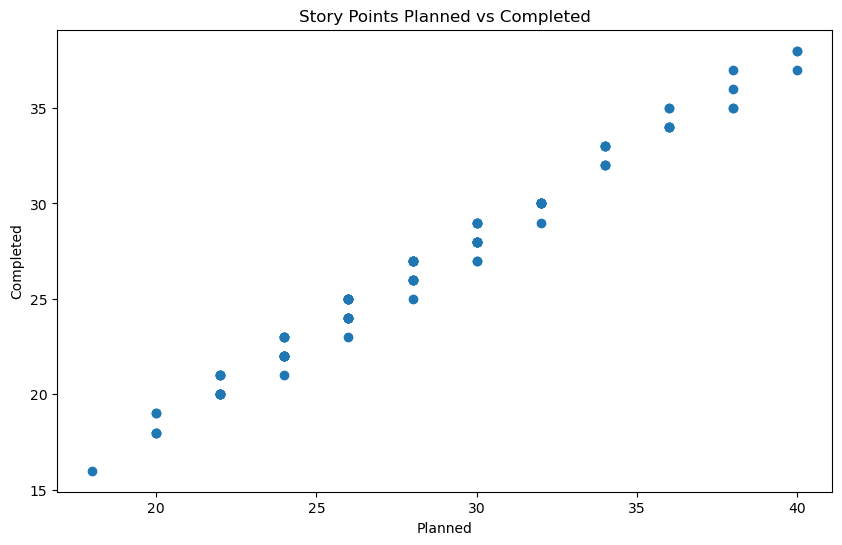

In [101]:
# Plotting story points planned vs completed
plt.figure(figsize=(10, 6))
plt.scatter(df['Story Points Planned'], df['Story Points Completed'])
plt.title('Story Points Planned vs Completed')
plt.xlabel('Planned')
plt.ylabel('Completed')
plt.show()

In [102]:
# Preprocess "Team Velocity (History)"
velocity_sequences = df['Team Velocity (History)'].apply(lambda x: [int(v) for v in x.split(', ')]).tolist()
velocity_padded = pad_sequences(velocity_sequences, padding='post')
scaler = MinMaxScaler()
velocity_padded_normalized = scaler.fit_transform(velocity_padded.flatten().reshape(-1, 1)).reshape(velocity_padded.shape)


In [105]:
# Scale other features
features_to_scale = ['Sprint Length (wks)', 'Tasks Planned', 'Story Points Planned', 'Blockers', 'Team Members']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features_to_scale])
# Prepare targets
targets = df[['Tasks Completed', 'Story Points Completed']].values

In [107]:
# Splitting the data into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(np.hstack((scaled_features, velocity_padded_normalized)), targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [109]:
# Preparing data for LSTM (reshaping velocity history to match LSTM input)
velocity_train = X_train[:, -velocity_padded_normalized.shape[1]:].reshape(-1, velocity_padded_normalized.shape[1], 1)
velocity_val = X_val[:, -velocity_padded_normalized.shape[1]:].reshape(-1, velocity_padded_normalized.shape[1], 1)
velocity_test = X_test[:, -velocity_padded_normalized.shape[1]:].reshape(-1, velocity_padded_normalized.shape[1], 1)

In [111]:
# MLP features excluding velocity history which is handled by LSTM
mlp_train_features = X_train[:, :-velocity_padded_normalized.shape[1]]
mlp_val_features = X_val[:, :-velocity_padded_normalized.shape[1]]
mlp_test_features = X_test[:, :-velocity_padded_normalized.shape[1]]

In [113]:
# MLP model
mlp_input = Input(shape=(mlp_train_features.shape[1],), name='MLP_Input')
mlp_model = Dense(64, activation='relu')(mlp_input)
mlp_model = Dense(32, activation='relu')(mlp_model)

# LSTM model
lstm_input = Input(shape=(velocity_padded_normalized.shape[1], 1), name='LSTM_Input')
lstm_model = LSTM(32, return_sequences=True)(lstm_input)
lstm_model = Flatten()(lstm_model)
lstm_model = Dense(32, activation='relu')(lstm_model)

In [115]:
# Concatenate models
combined = concatenate([mlp_model, lstm_model])

# Output layer
output = Dense(2, activation='linear', name='Output')(combined)  # Predicting two targets

model = Model(inputs=[mlp_input, lstm_input], outputs=output)

In [117]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ LSTM_Input (InputLayer)       │ (None, 5, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ MLP_Input (InputLayer)        │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 5, 32)             │           4,352 │ LSTM_Input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 64)                │             384 │ MLP_Input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 160)               │               0 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 32)                │           2,080 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 32)                │           5,152 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 64)                │               0 │ dense_4[0][0],             │
│                               │                           │                 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Output (Dense)                │ (None, 2)                 │             130 │ concatenate_1[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 12,098 (47.26 KB)

 Trainable params: 12,098 (47.26 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# Train the model
history = model.fit([mlp_train_features, velocity_train], y_train, validation_data=([mlp_val_features, velocity_val], y_val), epochs=100, batch_size=32)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 9.0691 - mae: 2.3246 - val_loss: 6.2238 - val_mae: 1.9284
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8.7377 - mae: 2.3054 - val_loss: 6.1315 - val_mae: 1.9118
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 8.2299 - mae: 2.2313 - val_loss: 6.0127 - val_mae: 1.8869
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 8.5624 - mae: 2.2520 - val_loss: 5.9217 - val_mae: 1.8703
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 8.0004 - mae: 2.2210 - val_loss: 5.8088 - val_mae: 1.8470
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 7.5386 - mae: 2.0874 - val_loss: 5.7001 - val_mae: 1.8246
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 7.8042 - mae: 2.1666 - val_loss: 5.6213 - val_mae: 1.8122
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.8420 - mae: 2.1349 - val_loss: 5.5559 - val_mae: 1.8036
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 7.5612 - mae:

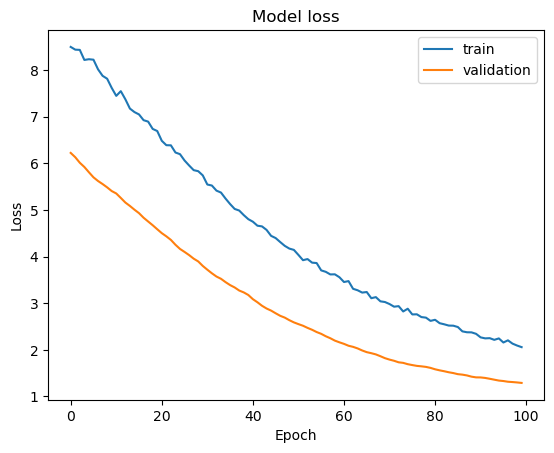

In [121]:
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [133]:
# Parsing and preprocessing the input data
team_velocity_history = np.array([15, 18, 20, 22, 25])
scaled_features = scaler.transform([[2, 25, 40, 3, 5]])  # Example scaling

# Assuming your ensemble model is ready and named `ensemble_model`
# And you have functions or steps to prepare the LSTM and MLP inputs correctly
prediction = model.predict([scaled_features, team_velocity_history.reshape(1, -1)])

print(f"Predicted Tasks Completed: {prediction[0,0]}")
print(f"Predicted Story Points Completed: {prediction[0,1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Tasks Completed: 21.139169692993164
Predicted Story Points Completed: 41.95823669433594
